In [8]:
import sys, os, pickle, math

from collections import namedtuple

from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.ndimage.filters import uniform_filter1d
from itertools import cycle

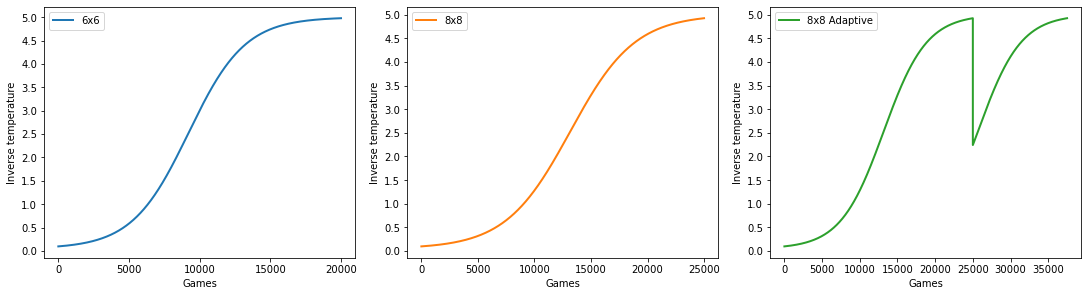

In [9]:
def t_6x6(i_episode):
    return 1 / (0.2 + (20 - 0.2) / (1 + math.e**(0.5 * (i_episode / 1000))))

def t_8x8(i_episode):
    return 1 / (0.2 + (20 - 0.2) / (1 + math.e**(0.35 * (i_episode / 1000))))

def t_8x8_changing(i_episode):
    if i_episode < 25000:
        return 1 / (0.2 + (20 - 0.2) / (1 + math.e**(0.35*(i_episode / 1000))))
    else:
        return 1 / (0.2 + (20 - 0.2) / (1 + math.e**(0.35*((i_episode - 12500) / 1000))))

fig = plt.figure(figsize=(15,4), constrained_layout=True)
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.set_xlabel('Games')
ax1.set_ylabel('Inverse temperature')
ax1.set_xticks(np.arange(0, 25000, 5000))
ax1.set_yticks(np.arange(0, 5.5, 0.5))

ax2.set_xlabel('Games')
ax2.set_ylabel('Inverse temperature')
ax2.set_xticks(np.arange(0, 30000, 5000))
ax2.set_yticks(np.arange(0, 5.5, 0.5))

ax3.set_xlabel('Games')
ax3.set_ylabel('Inverse temperature')
ax3.set_xticks(np.arange(0, 42500, 5000))
ax3.set_yticks(np.arange(0, 5.5, 0.5))

# 6x6
x_values = np.arange(0, 20000, 1)
y_values = np.array([t_6x6(x) for x in x_values])
ax1.plot(x_values, y_values, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=2, label='6x6')
ax1.legend()

# 8x8
x_values = np.arange(0, 25000, 1)
y_values = np.array([t_8x8(x) for x in x_values])
ax2.plot(x_values, y_values, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=2, label='8x8')
ax2.legend()

# 8x8 changing
x_values = np.arange(0, 37500, 1)
y_values = np.array([t_8x8_changing(x) for x in x_values])
ax3.plot(x_values, y_values, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=2, label='8x8 Adaptive')
ax3.legend()


In [10]:
from stats import EpisodeStats

globals()['EpisodeStats'] = EpisodeStats

def load_stats(stats_name):
    stats = None
    
    if os.path.isfile(stats_name + '.pkl'):
        with open(stats_name + '.pkl', 'rb') as f:
            stats = pickle.load(f)
            f.close()

    return stats

def save_stats(stats_name, stats):
    with open(stats_name + '.pkl', 'wb') as f:
        pickle.dump(stats, f, pickle.HIGHEST_PROTOCOL)
        f.close()

In [11]:
def process_model(name, num_episodes, model):
    unique, counts = np.unique(np.array(model.episode_results[:num_episodes]), return_counts=True)
    dict_results = dict(zip(unique, counts))
    
    results = [
        dict_results['W'] if 'W' in dict_results else 0, 
        dict_results['B'] if 'B' in dict_results else 0,
        dict_results['D'] if 'D' in dict_results else 0
    ]

    wins = np.cumsum(np.array(list(map(lambda x: 1 if x == 'W' else 0, model.episode_results[:num_episodes]))))
    wins2 = np.array(list(map(lambda x: 1 if x == 'W' else 0, model.episode_results[:num_episodes])))
    
    return PlotStats(
        name=name,
        results=results,
        wins=wins,
        wins2=wins2,
        rewards=model.episode_rewards[:num_episodes],
        steps=model.episode_steps[:num_episodes],
        states=model.explored_states[:num_episodes]
    )

def load_mean_model(name, num_episodes, n, r):
    results = []
    wins = []
    wins2 = []
    rewards = []
    steps = []
    states = []

    for i in range(r):
        model = process_model(name, num_episodes, load_stats(f'{n}_{i}'))
        results.append(model.results)
        wins.append(model.wins)
        wins2.append(model.wins2)
        rewards.append(model.rewards)
        steps.append(model.steps)
        states.append(model.states)
        
    return PlotStats(
        name=name,
        results=np.mean(results, axis=0),
        wins=np.mean(wins, axis=0),
        wins2=np.mean(wins2, axis=0),
        rewards=np.mean(rewards, axis=0),
        steps=np.mean(steps, axis=0),
        states=np.mean(states, axis=0)
    )

def load_best_model(name, num_episodes, n, r):
    models = []
    rewards = []
    
    for i in range(r):
        model = process_model(name, num_episodes, load_stats(f'{n}_{i}'))
        models.append(model)
        rewards.append(np.sum(model.rewards))
        
    return models[np.argmax(rewards)]

In [12]:
PlotStats = namedtuple('PlotStats', ['name', 'results', 'wins', 'wins2', 'rewards', 'steps', 'states'])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_results(ax, n, i, results, label):  
    xlabels = ['Agent wins', 'Opponent wins', 'Draw']
    
    y_values = np.rint(results).astype(int)
    
    width = 0.75
    x = np.arange(3) - 0.625 * width + (i + 1) / float(n) * width
    
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(xlabels)
    
    rects = ax.bar(x, y_values, width=width / float(n), label=label)
    ax.legend()
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    
def plot_rewards(ax, i, rewards, label, N=1000):    
    x_values = np.arange(0, rewards.size, 1)
    y_values = uniform_filter1d(rewards, N)
    
    ax.plot(x_values, y_values, c=colors[i], lw=2, label=label)
    ax.legend()
    
def plot_wins(ax, i, results, label):
    L = 100

    x_values = np.arange(L, results.size, 1)    
    y_values = np.array([np.sum(results[i:L+i]) / L for i in range(0, results.size - L)])
    y_values = uniform_filter1d(y_values, 250)
    
    ax.set_ylim(0.0, 1.0)
    
    ax.plot(x_values, y_values, c=colors[i], lw=2, label=label)
    ax.legend()

def plot_steps(ax, i, steps, label, N=1000):
    x_values = np.arange(0, steps.size, 1)
    y_values = uniform_filter1d(steps, N)

    ax.plot(x_values, y_values, c=colors[i], lw=2, label=label)
    ax.legend()
    
def plot_states(ax, i, states, label, N=1000):
    x_values = np.arange(0, states.size, 1)
    y_values = uniform_filter1d(states, N)

    ax.plot(x_values, y_values, c=colors[i], lw=2, label=label)
    ax.legend()

In [13]:
def plot_stats_simple(title, models, N=100):
    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, :])
    
    fig.suptitle(title)
    
    ax1.set_ylabel('Games')
    
    for i, model in enumerate(models):
        plot_results(ax1, len(models), i, model.results, label=model.name)
    

def plot_stats(title, models, N=100):
    fig = plt.figure(figsize=(15,12), constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[2,1])
    ax5 = fig.add_subplot(gs[2,2])
    
    fig.suptitle(title)
    
    ax1.set_ylabel('Games')

    ax2.set_xlabel('Games')
    ax2.set_ylabel('Average total reward')
    ax2.set_xlim(0, max([m.rewards.size for m in models]))
    
    ax3.set_xlabel('Games')
    ax3.set_ylabel('Win probability')

    ax4.set_xlabel('Games')
    ax4.set_ylabel('Explored states')

    ax5.set_xlabel('Games')
    ax5.set_ylabel('Number of moves')
    
    for i, model in enumerate(models):
        plot_results(ax1, len(models), i, model.results, label=model.name)
        plot_rewards(ax2, i, model.rewards, label=model.name, N=N)
        plot_wins(ax3, i, model.wins2, label=model.name)
        plot_states(ax4, i, model.states, label=model.name, N=N)
        plot_steps(ax5, i, model.steps, label=model.name, N=N)


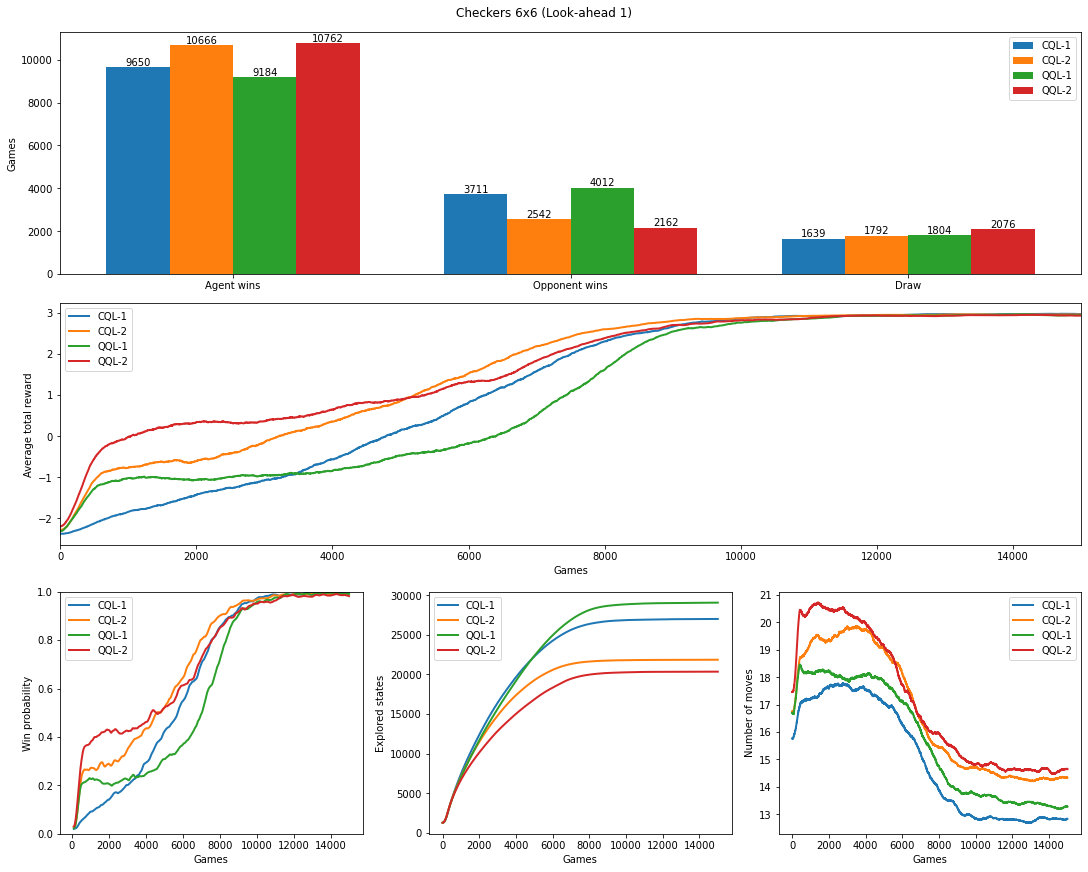

In [17]:
best = False
num_episodes = 15000
##############

load_func = load_best_model if best else load_mean_model

models = \
[load_func(f'CQL-{i-2}', num_episodes, f'stats/absolute/6x6_greedy/rql_{i:02}', 20) for i in [3, 4]] +\
[load_func(f'QQL-{i-2}', num_episodes, f'stats/absolute/6x6_greedy/qrql_{i:02}', 20) for i in [3, 4]]

plot_stats('Checkers 6x6 (Look-ahead 1)', models, N=500)
#plot_stats_simple('Checkers 6x6 (Look-ahead 1)', models, N=500)

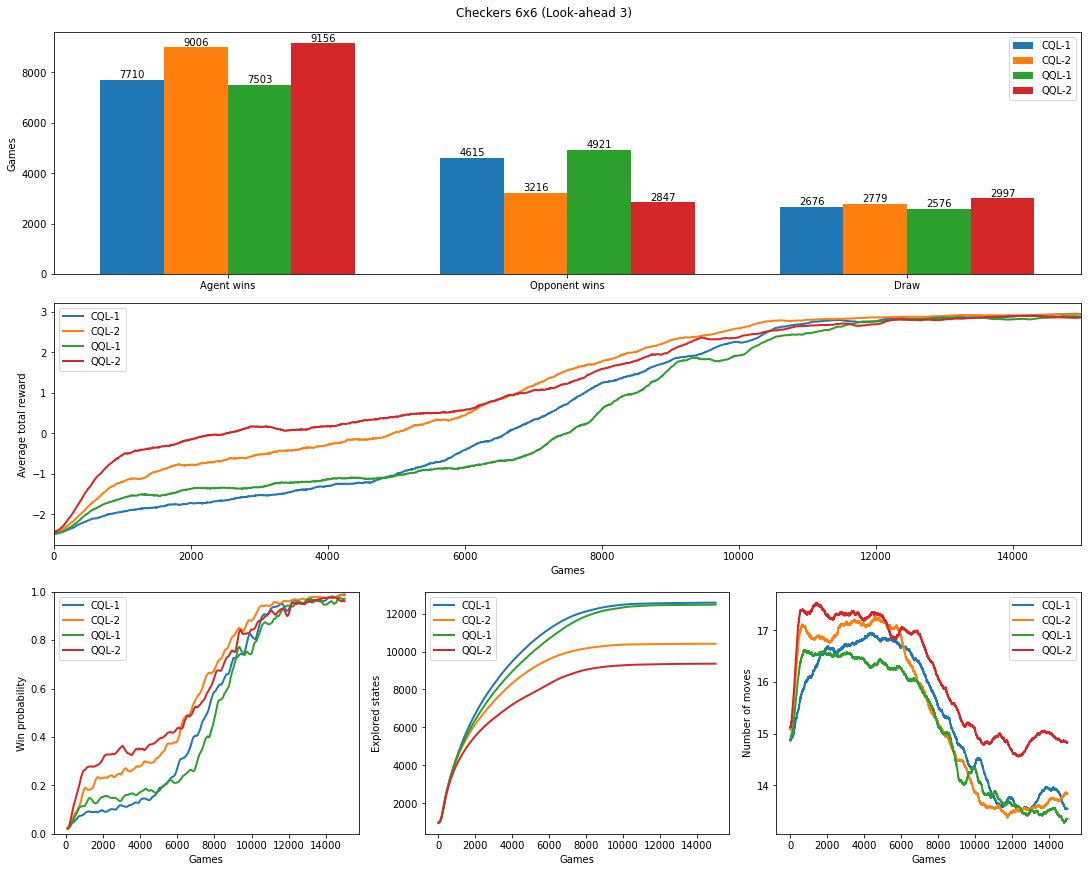

In [16]:
best = False
num_episodes = 15000
##############

load_func = load_best_model if best else load_mean_model

models = \
[load_func(f'CQL-{i-2}', num_episodes, f'stats/absolute/6x6_optimal3/rql_{i:02}', 20) for i in [3, 4]] +\
[load_func(f'QQL-{i-2}', num_episodes, f'stats/absolute/6x6_optimal3/qrql_{i:02}', 20) for i in [3, 4]]

plot_stats('Checkers 6x6 (Look-ahead 3)', models, N=500)
#plot_stats_simple('Checkers 6x6 (Look-ahead 3)', models, N=500)

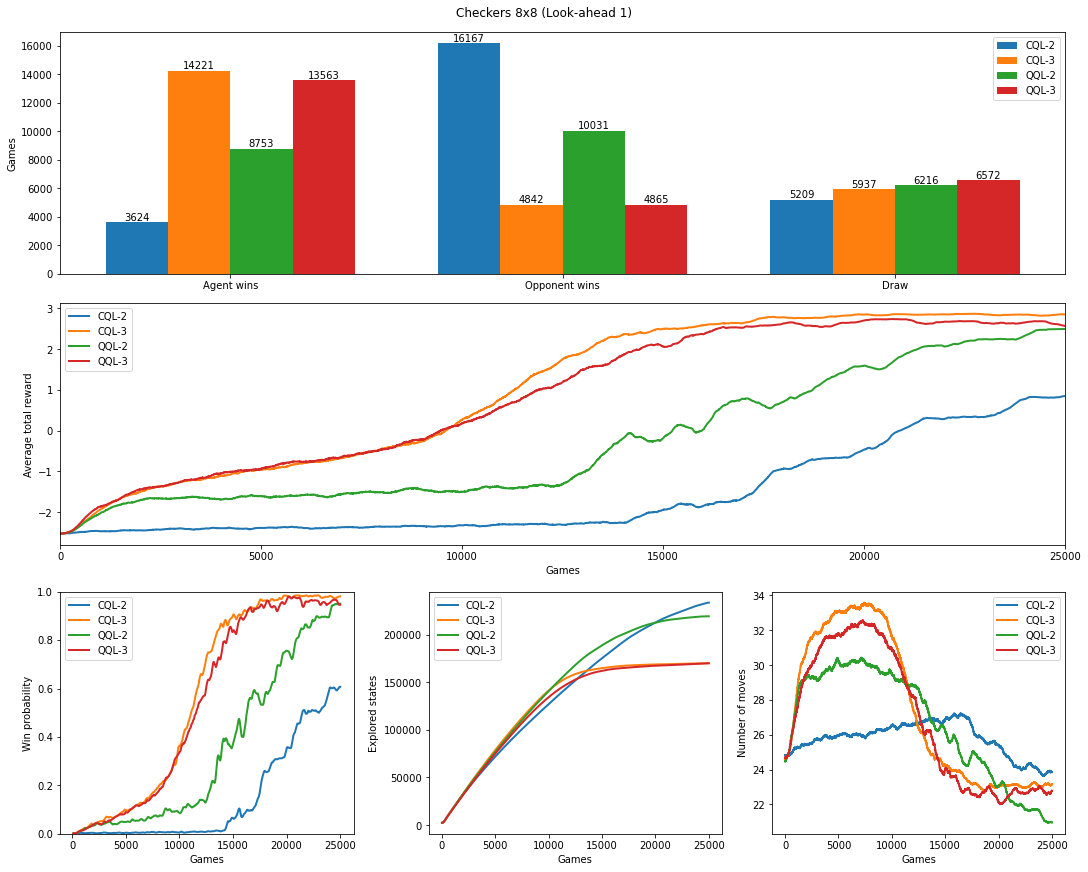

In [15]:
best = False
num_episodes = 25000

##############

load_func = load_best_model if best else load_mean_model

models = \
[load_func('CQL-2', num_episodes, f'stats/absolute/8x8_greedy/rql_{i:02}', 20) for i in [4]] +\
[load_func('CQL-3', num_episodes, f'stats/absolute/8x8_greedy/rql_{i:02}', 20) for i in [9]] +\
[load_func('QQL-2', num_episodes, f'stats/absolute/8x8_greedy/qrql_{i:02}', 20) for i in [4]] +\
[load_func('QQL-3', num_episodes, f'stats/absolute/8x8_greedy/qrql_{i:02}', 20) for i in [9]]

plot_stats('Checkers 8x8 (Look-ahead 1)', models, N=500)
#plot_stats_simple('Checkers 8x8 (Look-ahead 1)', models, N=500)

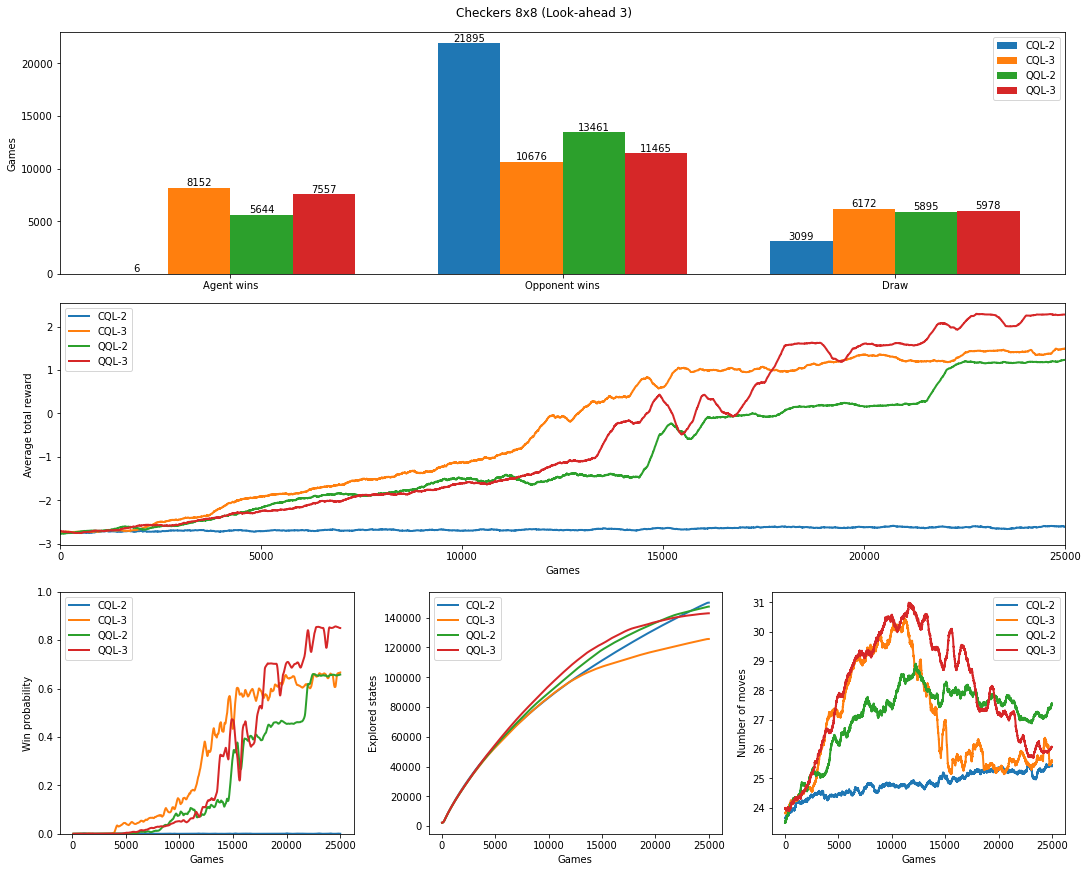

In [71]:
best = False
num_episodes = 25000

##############

load_func = load_best_model if best else load_mean_model

models = \
[load_func('CQL-2', num_episodes, f'stats/absolute/8x8_optimal3/rql_{i:02}', 20) for i in [4]] +\
[load_func('CQL-3', num_episodes, f'stats/absolute/8x8_optimal3/rql_{i:02}', 20) for i in [9]] +\
[load_func('QQL-2', num_episodes, f'stats/absolute/8x8_optimal3/qrql_{i:02}', 20) for i in [4]] +\
[load_func('QQL-3', num_episodes, f'stats/absolute/8x8_optimal3/qrql_{i:02}', 20) for i in [9]]

plot_stats('Checkers 8x8 (Look-ahead 3)', models, N=500)
#plot_stats_simple('Checkers 8x8 (Look-ahead 3)', models, N=500)

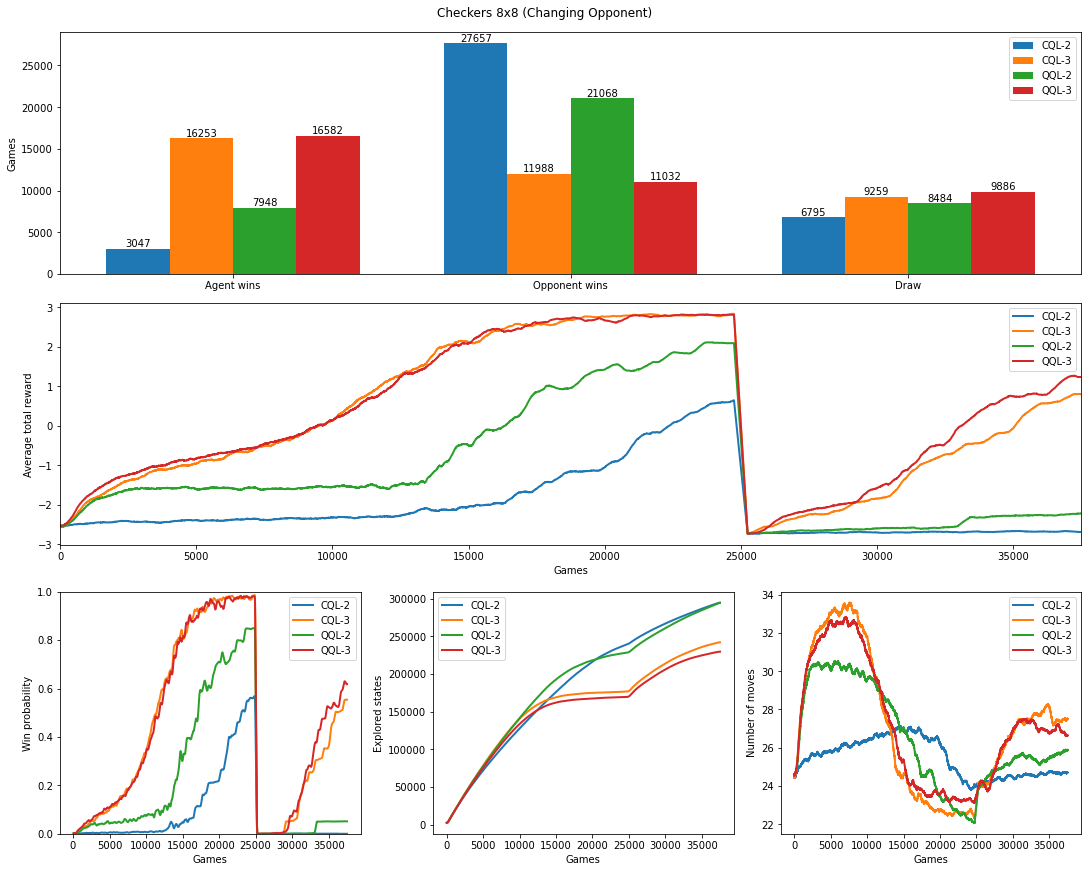

In [14]:
best = False
num_episodes = 37500

##############

load_func = load_best_model if best else load_mean_model

models = \
[load_func('CQL-2', num_episodes, f'stats/absolute/8x8_changing/rql_{i:02}', 20) for i in [4]] +\
[load_func('CQL-3', num_episodes, f'stats/absolute/8x8_changing/rql_{i:02}', 20) for i in [9]] +\
[load_func('QQL-2', num_episodes, f'stats/absolute/8x8_changing/qrql_{i:02}', 20) for i in [4]] +\
[load_func('QQL-3', num_episodes, f'stats/absolute/8x8_changing/qrql_{i:02}', 20) for i in [9]]

plot_stats('Checkers 8x8 (Changing Opponent)', models, N=500)
#plot_stats_simple('Checkers 8x8 (Changing Opponent)', models, N=500)